In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import warnings
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from numpy import split, array
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed, ConvLSTM2D
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Flatten, Dropout
from keras.optimizers import Adam
import numpy as np

In [5]:
import pandas as pd

# Load the dataset
path = '/content/drive/MyDrive/Data_Science/01_Projects/04_Pakistan_Energy_Demand/Data/pak_load_till_2023_output.csv'
dataset = pd.read_csv(path)

# Convert the 'datetime' columns to a single datetime column
dataset['datetime'] = pd.to_datetime(dataset[['YEAR', 'MONTH', 'DAY', 'Hour']])

# Set 'datetime' as the index
dataset.set_index('datetime', inplace=True)

# Drop unnecessary columns
dataset.drop(['YEAR', 'MONTH', 'DAY', 'Hour'], axis=1, inplace=True)

# Extract additional date-related features
dataset['year'] = dataset.index.year
dataset['month'] = dataset.index.month
dataset['dayofweek'] = dataset.index.dayofweek
dataset['hour'] = dataset.index.hour

# Display the first row of the modified dataset
print(dataset.head(10))


                         Demand  year  month  dayofweek  hour
datetime                                                     
2019-07-01 01:00:00  19615.2656  2019      7          0     1
2019-07-01 02:00:00  17842.2494  2019      7          0     2
2019-07-01 03:00:00  17663.2494  2019      7          0     3
2019-07-01 04:00:00  18715.0406  2019      7          0     4
2019-07-01 05:00:00  18839.8286  2019      7          0     5
2019-07-01 06:00:00  18170.1786  2019      7          0     6
2019-07-01 07:00:00  17795.2036  2019      7          0     7
2019-07-01 08:00:00  18957.4286  2019      7          0     8
2019-07-01 09:00:00  19725.1536  2019      7          0     9
2019-07-01 10:00:00  19885.4036  2019      7          0    10


In [6]:
dataset.head()
# Assuming you have a DataFrame df with your dataset
dataset = dataset[['year', 'month', 'dayofweek', 'hour', 'Demand']]
dataset.head(1)


,year,month,dayofweek,hour,Demand
datetime,,,,,
2019-07-01 01:00:00,2019,7,0,1,19615.2656


In [7]:
data = dataset

In [8]:
# Resample the dataset at a daily frequency and calculate the mean
newDataSet = data.resample("D").mean()
# Omit one row at the end of the resampled dataset
# 1646 -1 =1645/7 235 weeks
# 235 * 80 = 188 for train
# 235 - 188 = 47 for test
newDataSet = newDataSet.iloc[:-1]
# Display the first few rows of the resampled dataset
print(newDataSet.head())
print(newDataSet.shape)

              year  month  dayofweek  hour        Demand
datetime                                                
2019-07-01  2019.0    7.0        0.0  12.0  19309.086209
2019-07-02  2019.0    7.0        1.0  11.5  19667.606325
2019-07-03  2019.0    7.0        2.0  11.5  20422.855358
2019-07-04  2019.0    7.0        3.0  11.5  19702.835742
2019-07-05  2019.0    7.0        4.0  11.5  18838.397733
(1645, 5)


In [9]:
y = newDataSet["Demand"]
print(y[0])
y.shape

19309.08620869565


(1645,)

In [10]:
# Normalize data before model fitting
# it will boost the performance( in neural networks) + transform
from sklearn.preprocessing import MinMaxScaler
# scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM
scaler = MinMaxScaler(feature_range = (0,1))
# reshape: convert the univariate 1D array into 2D
y = scaler.fit_transform(np.array(y).reshape(-1,1))
print("Normalizing data before model fitting")
print(y[:10])

Normalizing data before model fitting
[[0.91806392]
 [0.94443899]
 [1.        ]
 [0.94703069]
 [0.88343703]
 [0.81160418]
 [0.89298101]
 [0.98384646]
 [0.9446605 ]
 [0.95068641]]


In [11]:
training_size = int(len(y)*0.80)
test_size = len(y)- training_size
val_size = int(training_size*0.20)
train_data , test_data , val_data = y[0:training_size-val_size,:] , y[training_size:len(y),:1], y[len(y)-test_size-val_size:len(y)-test_size,:1]


In [12]:
# building input variable
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [] , []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)


In [13]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)


In [14]:

# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (952, 100, 1)
X_test shape:  (228, 100, 1)
X_val shape:  (162, 100, 1)


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Flatten, Dropout
from keras.optimizers import Adam
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    n_conv_layers = trial.suggest_int('n_conv_layers', 1, 4)
    conv_filters = trial.suggest_int('conv_filters', 16, 128)
    conv_kernel_size = trial.suggest_int('conv_kernel_size', 3, 7)
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 4)
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

    # Create the CNN-LSTM model based on the hyperparameters
    model = Sequential()
    model.add(Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, activation='relu'))
    for _ in range(n_lstm_layers):
        model.add(LSTM(units=lstm_units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, yval), epochs=30, batch_size=32, verbose=2)

    # Return the validation loss as the optimization metric
    return np.min(history.history['val_loss'])

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize hyperparameters
study.optimize(objective, n_trials=10)

# Get the best hyperparameters and create the best model
best_params = study.best_params
best_model = Sequential()
best_model.add(Conv1D(filters=best_params['conv_filters'], kernel_size=best_params['conv_kernel_size'], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(Conv1D(filters=best_params['conv_filters'], kernel_size=best_params['conv_kernel_size'], activation='relu'))
for _ in range(best_params['n_lstm_layers']):
    best_model.add(LSTM(units=best_params['lstm_units'], return_sequences=True))
    best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(LSTM(units=best_params['lstm_units']))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(1))
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')





[I 2023-10-17 06:03:03,242] A new study created in memory with name: no-name-488b821d-3e06-4949-b36c-9301bd8e1730
<ipython-input-14-848e06088ea9>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
<ipython-input-14-848e06088ea9>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/30
30/30 - 26s - loss: 0.2518 - val_loss: 0.2073 - 26s/epoch - 860ms/step
Epoch 2/30
30/30 - 0s - loss: 0.2152 - val_loss: 0.1705 - 426ms/epoch - 14ms/step
Epoch 3/30
30/30 - 0s - loss: 0.1771 - val_loss: 0.1313 - 419ms/epoch - 14ms/step
Epoch 4/30
30/30 - 0s - loss: 0.1363 - val_loss: 0.0878 - 432ms/epoch - 14ms/step
Epoch 5/30
30/30 - 0s - loss: 0.0913 - val_loss: 0.0437 - 426ms/epoch - 14ms/step
Epoch 6/30
30/30 - 0s - loss: 0.0487 - val_loss: 0.0126 - 443ms/epoch - 15ms/step
Epoch 7/30
30/30 - 0s - loss: 0.0244 - val_loss: 0.0075 - 448ms/epoch - 15ms/step
Epoch 8/30
30/30 - 0s - loss: 0.0197 - val_loss: 0.0095 - 407ms/epoch - 14ms/step
Epoch 9/30
30/30 - 0s - loss: 0.0186 - val_loss: 0.0091 - 418ms/epoch - 14ms/step
Epoch 10/30
30/30 - 0s - loss: 0.0175 - val_loss: 0.0084 - 444ms/epoch - 15ms/step
Epoch 11/30
30/30 - 0s - loss: 0.0182 - val_loss: 0.0090 - 416ms/epoch - 14ms/step
Epoch 12/30
30/30 - 0s - loss: 0.0180 - val_loss: 0.0082 - 415ms/epoch - 14ms/step
Epoch 13/30
3

[I 2023-10-17 06:03:57,493] Trial 0 finished with value: 0.006707686930894852 and parameters: {'n_conv_layers': 3, 'conv_filters': 115, 'conv_kernel_size': 3, 'n_lstm_layers': 2, 'lstm_units': 79, 'learning_rate': 1.06851834792937e-05, 'dropout_rate': 0.3591682281181119}. Best is trial 0 with value: 0.006707686930894852.


Epoch 1/30
30/30 - 8s - loss: 0.0703 - val_loss: 0.0226 - 8s/epoch - 283ms/step
Epoch 2/30
30/30 - 0s - loss: 0.0100 - val_loss: 0.0104 - 431ms/epoch - 14ms/step
Epoch 3/30
30/30 - 0s - loss: 0.0075 - val_loss: 0.0039 - 447ms/epoch - 15ms/step
Epoch 4/30
30/30 - 0s - loss: 0.0058 - val_loss: 0.0027 - 443ms/epoch - 15ms/step
Epoch 5/30
30/30 - 0s - loss: 0.0051 - val_loss: 0.0030 - 437ms/epoch - 15ms/step
Epoch 6/30
30/30 - 0s - loss: 0.0052 - val_loss: 0.0020 - 445ms/epoch - 15ms/step
Epoch 7/30
30/30 - 1s - loss: 0.0042 - val_loss: 0.0015 - 545ms/epoch - 18ms/step
Epoch 8/30
30/30 - 1s - loss: 0.0062 - val_loss: 0.0052 - 590ms/epoch - 20ms/step
Epoch 9/30
30/30 - 1s - loss: 0.0051 - val_loss: 0.0020 - 598ms/epoch - 20ms/step
Epoch 10/30
30/30 - 1s - loss: 0.0042 - val_loss: 0.0017 - 593ms/epoch - 20ms/step
Epoch 11/30
30/30 - 1s - loss: 0.0042 - val_loss: 0.0013 - 585ms/epoch - 20ms/step
Epoch 12/30
30/30 - 1s - loss: 0.0044 - val_loss: 0.0012 - 575ms/epoch - 19ms/step
Epoch 13/30
30/

[I 2023-10-17 06:04:20,910] Trial 1 finished with value: 0.0007345278281718493 and parameters: {'n_conv_layers': 4, 'conv_filters': 127, 'conv_kernel_size': 4, 'n_lstm_layers': 2, 'lstm_units': 117, 'learning_rate': 0.002840046480799287, 'dropout_rate': 0.2852599104180706}. Best is trial 1 with value: 0.0007345278281718493.


Epoch 1/30
30/30 - 9s - loss: 0.2218 - val_loss: 0.1416 - 9s/epoch - 297ms/step
Epoch 2/30
30/30 - 0s - loss: 0.1086 - val_loss: 0.0253 - 308ms/epoch - 10ms/step
Epoch 3/30
30/30 - 0s - loss: 0.0240 - val_loss: 0.0118 - 351ms/epoch - 12ms/step
Epoch 4/30
30/30 - 0s - loss: 0.0168 - val_loss: 0.0062 - 305ms/epoch - 10ms/step
Epoch 5/30
30/30 - 0s - loss: 0.0172 - val_loss: 0.0062 - 309ms/epoch - 10ms/step
Epoch 6/30
30/30 - 0s - loss: 0.0166 - val_loss: 0.0053 - 327ms/epoch - 11ms/step
Epoch 7/30
30/30 - 0s - loss: 0.0142 - val_loss: 0.0061 - 304ms/epoch - 10ms/step
Epoch 8/30
30/30 - 0s - loss: 0.0148 - val_loss: 0.0058 - 332ms/epoch - 11ms/step
Epoch 9/30
30/30 - 0s - loss: 0.0140 - val_loss: 0.0043 - 325ms/epoch - 11ms/step
Epoch 10/30
30/30 - 0s - loss: 0.0135 - val_loss: 0.0059 - 299ms/epoch - 10ms/step
Epoch 11/30
30/30 - 0s - loss: 0.0127 - val_loss: 0.0047 - 350ms/epoch - 12ms/step
Epoch 12/30
30/30 - 0s - loss: 0.0125 - val_loss: 0.0042 - 325ms/epoch - 11ms/step
Epoch 13/30
30/

[I 2023-10-17 06:04:48,034] Trial 2 finished with value: 0.0017150497296825051 and parameters: {'n_conv_layers': 2, 'conv_filters': 54, 'conv_kernel_size': 3, 'n_lstm_layers': 1, 'lstm_units': 80, 'learning_rate': 4.862385061745338e-05, 'dropout_rate': 0.4183240899758921}. Best is trial 1 with value: 0.0007345278281718493.


Epoch 1/30
30/30 - 9s - loss: 0.1263 - val_loss: 0.0412 - 9s/epoch - 311ms/step
Epoch 2/30
30/30 - 0s - loss: 0.0243 - val_loss: 0.0150 - 419ms/epoch - 14ms/step
Epoch 3/30
30/30 - 0s - loss: 0.0181 - val_loss: 0.0135 - 448ms/epoch - 15ms/step
Epoch 4/30
30/30 - 0s - loss: 0.0168 - val_loss: 0.0117 - 412ms/epoch - 14ms/step
Epoch 5/30
30/30 - 0s - loss: 0.0153 - val_loss: 0.0100 - 422ms/epoch - 14ms/step
Epoch 6/30
30/30 - 0s - loss: 0.0145 - val_loss: 0.0085 - 414ms/epoch - 14ms/step
Epoch 7/30
30/30 - 0s - loss: 0.0127 - val_loss: 0.0092 - 414ms/epoch - 14ms/step
Epoch 8/30
30/30 - 0s - loss: 0.0124 - val_loss: 0.0064 - 413ms/epoch - 14ms/step
Epoch 9/30
30/30 - 0s - loss: 0.0111 - val_loss: 0.0046 - 412ms/epoch - 14ms/step
Epoch 10/30
30/30 - 0s - loss: 0.0107 - val_loss: 0.0109 - 421ms/epoch - 14ms/step
Epoch 11/30
30/30 - 0s - loss: 0.0095 - val_loss: 0.0031 - 436ms/epoch - 15ms/step
Epoch 12/30
30/30 - 0s - loss: 0.0088 - val_loss: 0.0031 - 469ms/epoch - 16ms/step
Epoch 13/30
30/

[I 2023-10-17 06:05:15,093] Trial 3 finished with value: 0.0023652170784771442 and parameters: {'n_conv_layers': 4, 'conv_filters': 21, 'conv_kernel_size': 6, 'n_lstm_layers': 2, 'lstm_units': 119, 'learning_rate': 8.197582352167343e-05, 'dropout_rate': 0.4122048070438963}. Best is trial 1 with value: 0.0007345278281718493.


Epoch 1/30
30/30 - 13s - loss: 0.0991 - val_loss: 0.0090 - 13s/epoch - 431ms/step
Epoch 2/30
30/30 - 1s - loss: 0.0108 - val_loss: 0.0038 - 626ms/epoch - 21ms/step
Epoch 3/30
30/30 - 1s - loss: 0.0057 - val_loss: 0.0092 - 622ms/epoch - 21ms/step
Epoch 4/30
30/30 - 1s - loss: 0.0064 - val_loss: 0.0028 - 618ms/epoch - 21ms/step
Epoch 5/30
30/30 - 1s - loss: 0.0051 - val_loss: 0.0037 - 631ms/epoch - 21ms/step
Epoch 6/30
30/30 - 1s - loss: 0.0044 - val_loss: 0.0044 - 628ms/epoch - 21ms/step
Epoch 7/30
30/30 - 1s - loss: 0.0045 - val_loss: 0.0042 - 760ms/epoch - 25ms/step
Epoch 8/30
30/30 - 1s - loss: 0.0039 - val_loss: 0.0023 - 885ms/epoch - 29ms/step
Epoch 9/30
30/30 - 1s - loss: 0.0038 - val_loss: 0.0019 - 898ms/epoch - 30ms/step
Epoch 10/30
30/30 - 1s - loss: 0.0041 - val_loss: 0.0019 - 875ms/epoch - 29ms/step
Epoch 11/30
30/30 - 1s - loss: 0.0035 - val_loss: 0.0017 - 865ms/epoch - 29ms/step
Epoch 12/30
30/30 - 1s - loss: 0.0034 - val_loss: 0.0019 - 624ms/epoch - 21ms/step
Epoch 13/30
3

[I 2023-10-17 06:06:05,437] Trial 4 finished with value: 0.000873597979079932 and parameters: {'n_conv_layers': 1, 'conv_filters': 17, 'conv_kernel_size': 4, 'n_lstm_layers': 4, 'lstm_units': 77, 'learning_rate': 0.003581262476860108, 'dropout_rate': 0.012896090396946336}. Best is trial 1 with value: 0.0007345278281718493.


Epoch 1/30
30/30 - 14s - loss: 0.1191 - val_loss: 0.0134 - 14s/epoch - 455ms/step
Epoch 2/30
30/30 - 1s - loss: 0.0179 - val_loss: 0.0308 - 646ms/epoch - 22ms/step
Epoch 3/30
30/30 - 1s - loss: 0.0159 - val_loss: 0.0117 - 641ms/epoch - 21ms/step
Epoch 4/30
30/30 - 1s - loss: 0.0105 - val_loss: 0.0029 - 640ms/epoch - 21ms/step
Epoch 5/30
30/30 - 1s - loss: 0.0086 - val_loss: 0.0034 - 652ms/epoch - 22ms/step
Epoch 6/30
30/30 - 1s - loss: 0.0077 - val_loss: 0.0028 - 645ms/epoch - 21ms/step
Epoch 7/30
30/30 - 1s - loss: 0.0070 - val_loss: 0.0022 - 651ms/epoch - 22ms/step
Epoch 8/30
30/30 - 1s - loss: 0.0066 - val_loss: 0.0038 - 647ms/epoch - 22ms/step
Epoch 9/30
30/30 - 1s - loss: 0.0053 - val_loss: 0.0018 - 630ms/epoch - 21ms/step
Epoch 10/30
30/30 - 1s - loss: 0.0058 - val_loss: 0.0106 - 643ms/epoch - 21ms/step
Epoch 11/30
30/30 - 1s - loss: 0.0061 - val_loss: 0.0015 - 728ms/epoch - 24ms/step
Epoch 12/30
30/30 - 1s - loss: 0.0048 - val_loss: 0.0034 - 836ms/epoch - 28ms/step
Epoch 13/30
3

[I 2023-10-17 06:06:40,192] Trial 5 finished with value: 0.0009686254197731614 and parameters: {'n_conv_layers': 4, 'conv_filters': 59, 'conv_kernel_size': 6, 'n_lstm_layers': 4, 'lstm_units': 114, 'learning_rate': 0.009040660053690495, 'dropout_rate': 0.3726298266831717}. Best is trial 1 with value: 0.0007345278281718493.


Epoch 1/30
30/30 - 8s - loss: 0.0507 - val_loss: 0.0130 - 8s/epoch - 281ms/step
Epoch 2/30
30/30 - 0s - loss: 0.0110 - val_loss: 0.0072 - 437ms/epoch - 15ms/step
Epoch 3/30
30/30 - 0s - loss: 0.0075 - val_loss: 0.0064 - 436ms/epoch - 15ms/step
Epoch 4/30
30/30 - 0s - loss: 0.0048 - val_loss: 0.0034 - 414ms/epoch - 14ms/step
Epoch 5/30
30/30 - 0s - loss: 0.0045 - val_loss: 0.0027 - 395ms/epoch - 13ms/step
Epoch 6/30
30/30 - 0s - loss: 0.0040 - val_loss: 0.0031 - 411ms/epoch - 14ms/step
Epoch 7/30
30/30 - 0s - loss: 0.0039 - val_loss: 0.0019 - 433ms/epoch - 14ms/step
Epoch 8/30
30/30 - 0s - loss: 0.0036 - val_loss: 0.0017 - 415ms/epoch - 14ms/step
Epoch 9/30
30/30 - 0s - loss: 0.0035 - val_loss: 0.0016 - 442ms/epoch - 15ms/step
Epoch 10/30
30/30 - 0s - loss: 0.0033 - val_loss: 0.0020 - 418ms/epoch - 14ms/step
Epoch 11/30
30/30 - 0s - loss: 0.0032 - val_loss: 0.0029 - 412ms/epoch - 14ms/step
Epoch 12/30
30/30 - 0s - loss: 0.0034 - val_loss: 0.0015 - 487ms/epoch - 16ms/step
Epoch 13/30
30/

[I 2023-10-17 06:07:06,768] Trial 6 finished with value: 0.0009778375970199704 and parameters: {'n_conv_layers': 2, 'conv_filters': 83, 'conv_kernel_size': 4, 'n_lstm_layers': 2, 'lstm_units': 44, 'learning_rate': 0.0004541205646693629, 'dropout_rate': 0.0063109286132709275}. Best is trial 1 with value: 0.0007345278281718493.


Epoch 1/30
30/30 - 9s - loss: 0.0449 - val_loss: 0.0103 - 9s/epoch - 315ms/step
Epoch 2/30
30/30 - 0s - loss: 0.0157 - val_loss: 0.0039 - 454ms/epoch - 15ms/step
Epoch 3/30
30/30 - 0s - loss: 0.0127 - val_loss: 0.0038 - 409ms/epoch - 14ms/step
Epoch 4/30
30/30 - 0s - loss: 0.0116 - val_loss: 0.0025 - 412ms/epoch - 14ms/step
Epoch 5/30
30/30 - 0s - loss: 0.0108 - val_loss: 0.0022 - 430ms/epoch - 14ms/step
Epoch 6/30
30/30 - 0s - loss: 0.0101 - val_loss: 0.0044 - 421ms/epoch - 14ms/step
Epoch 7/30
30/30 - 0s - loss: 0.0096 - val_loss: 0.0023 - 415ms/epoch - 14ms/step
Epoch 8/30
30/30 - 0s - loss: 0.0090 - val_loss: 0.0022 - 406ms/epoch - 14ms/step
Epoch 9/30
30/30 - 0s - loss: 0.0091 - val_loss: 0.0035 - 405ms/epoch - 14ms/step
Epoch 10/30
30/30 - 0s - loss: 0.0090 - val_loss: 0.0023 - 404ms/epoch - 13ms/step
Epoch 11/30
30/30 - 0s - loss: 0.0082 - val_loss: 0.0028 - 403ms/epoch - 13ms/step
Epoch 12/30
30/30 - 0s - loss: 0.0087 - val_loss: 0.0030 - 439ms/epoch - 15ms/step
Epoch 13/30
30/

[I 2023-10-17 06:07:34,042] Trial 7 finished with value: 0.001506072818301618 and parameters: {'n_conv_layers': 1, 'conv_filters': 37, 'conv_kernel_size': 6, 'n_lstm_layers': 2, 'lstm_units': 53, 'learning_rate': 0.0012700240950204457, 'dropout_rate': 0.4355367252372294}. Best is trial 1 with value: 0.0007345278281718493.


Epoch 1/30
30/30 - 10s - loss: 0.1657 - val_loss: 0.0482 - 10s/epoch - 340ms/step
Epoch 2/30
30/30 - 0s - loss: 0.0326 - val_loss: 0.0129 - 302ms/epoch - 10ms/step
Epoch 3/30
30/30 - 0s - loss: 0.0189 - val_loss: 0.0060 - 304ms/epoch - 10ms/step
Epoch 4/30
30/30 - 0s - loss: 0.0162 - val_loss: 0.0064 - 348ms/epoch - 12ms/step
Epoch 5/30
30/30 - 0s - loss: 0.0158 - val_loss: 0.0063 - 350ms/epoch - 12ms/step
Epoch 6/30
30/30 - 0s - loss: 0.0155 - val_loss: 0.0054 - 307ms/epoch - 10ms/step
Epoch 7/30
30/30 - 0s - loss: 0.0148 - val_loss: 0.0054 - 315ms/epoch - 10ms/step
Epoch 8/30
30/30 - 0s - loss: 0.0141 - val_loss: 0.0042 - 309ms/epoch - 10ms/step
Epoch 9/30
30/30 - 0s - loss: 0.0128 - val_loss: 0.0037 - 302ms/epoch - 10ms/step
Epoch 10/30
30/30 - 0s - loss: 0.0127 - val_loss: 0.0034 - 306ms/epoch - 10ms/step
Epoch 11/30
30/30 - 0s - loss: 0.0120 - val_loss: 0.0046 - 319ms/epoch - 11ms/step
Epoch 12/30
30/30 - 0s - loss: 0.0114 - val_loss: 0.0045 - 323ms/epoch - 11ms/step
Epoch 13/30
3

[I 2023-10-17 06:08:02,818] Trial 8 finished with value: 0.0016248765168711543 and parameters: {'n_conv_layers': 3, 'conv_filters': 90, 'conv_kernel_size': 5, 'n_lstm_layers': 1, 'lstm_units': 73, 'learning_rate': 6.191735379776056e-05, 'dropout_rate': 0.4832459941005965}. Best is trial 1 with value: 0.0007345278281718493.


Epoch 1/30
30/30 - 9s - loss: 0.1460 - val_loss: 0.0098 - 9s/epoch - 312ms/step
Epoch 2/30
30/30 - 0s - loss: 0.0163 - val_loss: 0.0078 - 427ms/epoch - 14ms/step
Epoch 3/30
30/30 - 0s - loss: 0.0119 - val_loss: 0.0067 - 449ms/epoch - 15ms/step
Epoch 4/30
30/30 - 0s - loss: 0.0113 - val_loss: 0.0066 - 425ms/epoch - 14ms/step
Epoch 5/30
30/30 - 0s - loss: 0.0098 - val_loss: 0.0067 - 415ms/epoch - 14ms/step
Epoch 6/30
30/30 - 0s - loss: 0.0089 - val_loss: 0.0078 - 420ms/epoch - 14ms/step
Epoch 7/30
30/30 - 0s - loss: 0.0082 - val_loss: 0.0066 - 424ms/epoch - 14ms/step
Epoch 8/30
30/30 - 0s - loss: 0.0075 - val_loss: 0.0034 - 420ms/epoch - 14ms/step
Epoch 9/30
30/30 - 0s - loss: 0.0065 - val_loss: 0.0039 - 422ms/epoch - 14ms/step
Epoch 10/30
30/30 - 0s - loss: 0.0059 - val_loss: 0.0029 - 414ms/epoch - 14ms/step
Epoch 11/30
30/30 - 0s - loss: 0.0058 - val_loss: 0.0029 - 448ms/epoch - 15ms/step
Epoch 12/30
30/30 - 0s - loss: 0.0053 - val_loss: 0.0025 - 490ms/epoch - 16ms/step
Epoch 13/30
30/

[I 2023-10-17 06:08:26,469] Trial 9 finished with value: 0.0018543873447924852 and parameters: {'n_conv_layers': 2, 'conv_filters': 53, 'conv_kernel_size': 3, 'n_lstm_layers': 2, 'lstm_units': 88, 'learning_rate': 7.847563897410728e-05, 'dropout_rate': 0.04838098726502488}. Best is trial 1 with value: 0.0007345278281718493.


In [ ]:
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 97, 127)           635       
                                                                 
 conv1d_21 (Conv1D)          (None, 94, 127)           64643     
                                                                 
 lstm_32 (LSTM)              (None, 94, 117)           114660    
                                                                 
 dropout_32 (Dropout)        (None, 94, 117)           0         
                                                                 
 lstm_33 (LSTM)              (None, 94, 117)           109980    
                                                                 
 dropout_33 (Dropout)        (None, 94, 117)           0         
                                                                 
 lstm_34 (LSTM)              (None, 117)             

In [ ]:
history = best_model.fit(X_train, y_train, validation_data=(X_val, yval), epochs=60, batch_size=32, verbose=2)


Epoch 1/60
30/30 - 9s - loss: 0.1067 - val_loss: 0.0147 - 9s/epoch - 285ms/step
Epoch 2/60
30/30 - 1s - loss: 0.0083 - val_loss: 0.0026 - 588ms/epoch - 20ms/step
Epoch 3/60
30/30 - 1s - loss: 0.0074 - val_loss: 0.0022 - 535ms/epoch - 18ms/step
Epoch 4/60
30/30 - 0s - loss: 0.0056 - val_loss: 0.0018 - 451ms/epoch - 15ms/step
Epoch 5/60
30/30 - 0s - loss: 0.0053 - val_loss: 0.0056 - 448ms/epoch - 15ms/step
Epoch 6/60
30/30 - 0s - loss: 0.0062 - val_loss: 0.0017 - 442ms/epoch - 15ms/step
Epoch 7/60
30/30 - 0s - loss: 0.0047 - val_loss: 0.0015 - 437ms/epoch - 15ms/step
Epoch 8/60
30/30 - 0s - loss: 0.0048 - val_loss: 0.0062 - 438ms/epoch - 15ms/step
Epoch 9/60
30/30 - 0s - loss: 0.0048 - val_loss: 0.0017 - 435ms/epoch - 14ms/step
Epoch 10/60
30/30 - 0s - loss: 0.0039 - val_loss: 0.0021 - 442ms/epoch - 15ms/step
Epoch 11/60
30/30 - 0s - loss: 0.0044 - val_loss: 0.0013 - 444ms/epoch - 15ms/step
Epoch 12/60
30/30 - 0s - loss: 0.0042 - val_loss: 0.0014 - 448ms/epoch - 15ms/step
Epoch 13/60
30/

In [ ]:
history = best_model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 20)


In [ ]:
best_model.save('/content/drive/MyDrive/Data_Science/01_Projects/04_Pakistan_Energy_Demand/Trained_models/CNN_LSTM')

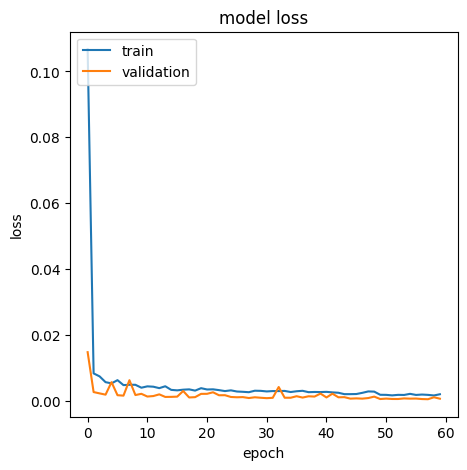

In [ ]:

plt.figure(figsize=(5,5))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
import tensorflow as tf
tf.__version__


'2.13.0'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=best_model.predict(X_train)
test_predict=best_model.predict(X_test)
val_predict=best_model.predict(X_val)

6/6 [==============================] - 0s 9ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)


In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

13318.211245031875

In [ ]:

print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)

(952, 1)
(228, 1)
(162, 1)
[12218.677]
(952,)


30/30 [==============================] - 0s 6ms/step
   Train Predictions       Actuals
0       12218.676758  12745.291667
1       12893.525391  13085.636875
2       13287.183594  12963.596458
3       13082.774414  13306.939167
4       13173.770508  13335.713517
5       13265.522461  13532.514442
6       13344.678711  13697.518875
7       13452.142578  13671.797600
8       13436.442383  13051.270142
9       12970.583008  10742.702592


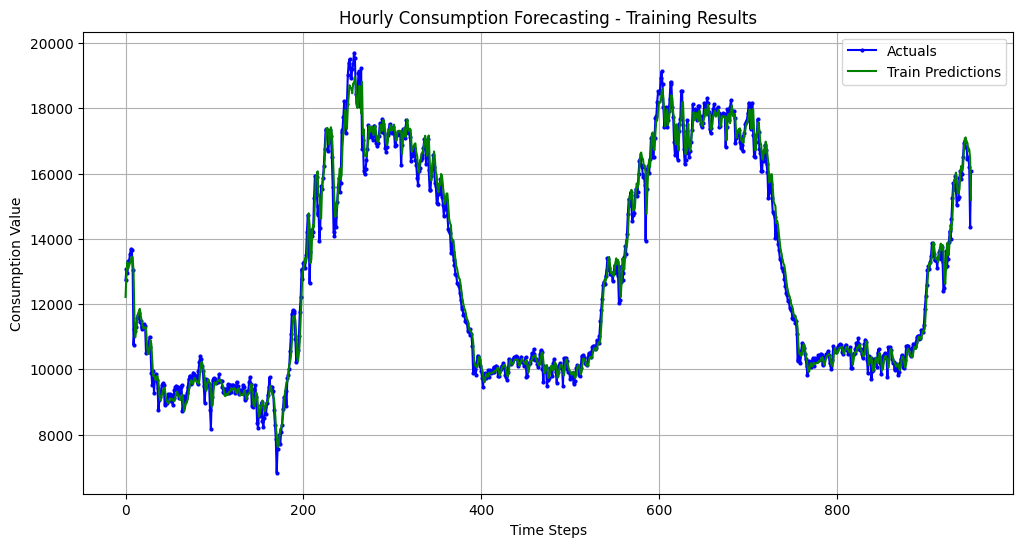

In [ ]:
import matplotlib.pyplot as plt

# Predict consumption using training data
train_predictions = best_model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)

# Create NumPy arrays for train predictions and actual values
train_predictions_array = train_predictions.flatten()
actual_array = actual.flatten()

# Create a DataFrame for easier plotting
train_results = pd.DataFrame({'Train Predictions': train_predictions_array, 'Actuals': actual_array})
print(train_results.head(10))

# Plot the training results
plt.figure(figsize=(12, 6))
plt.plot(train_results.index, train_results['Actuals'], label='Actuals', color='blue', marker='o', markersize=2)
plt.plot(train_results.index, train_results['Train Predictions'], label='Train Predictions', color='green', markersize=2)

plt.xlabel('Time Steps')
plt.ylabel('Consumption Value')
plt.title('Hourly Consumption Forecasting - Training Results')
plt.legend()
plt.grid(True)
plt.show()


6/6 [==============================] - 0s 7ms/step


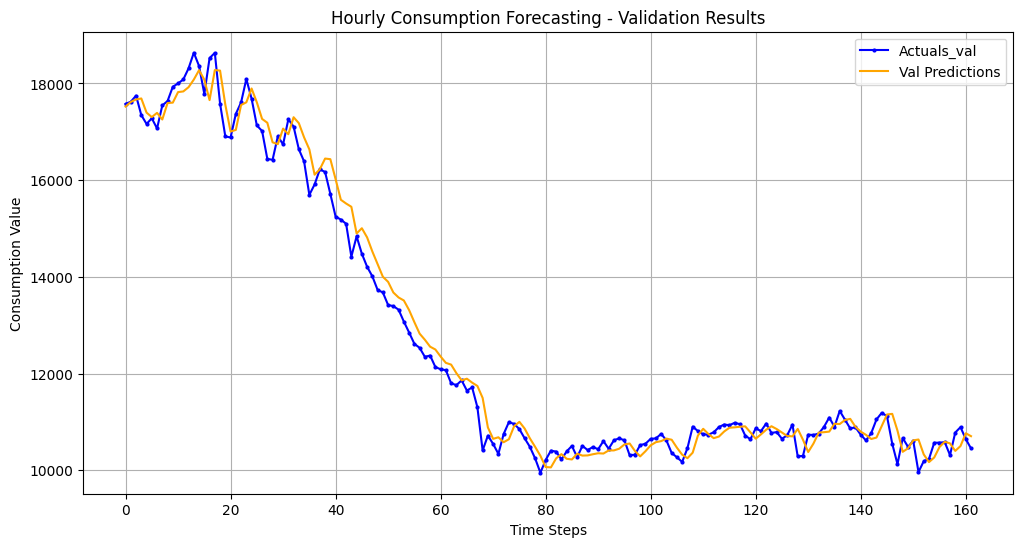

In [ ]:
import matplotlib.pyplot as plt

# Predict consumption using validation data
val_predictions = best_model.predict(X_val)
val_predictions = scaler.inverse_transform(val_predictions)

yval = yval.reshape(yval.shape[0], 1)
actual_val = scaler.inverse_transform(yval)

# Create NumPy arrays for validation predictions and actual values
val_predictions_array = val_predictions.flatten()
actual_val_array = actual_val.flatten()

# Create a DataFrame for easier plotting
val_results = pd.DataFrame({'Val Predictions': val_predictions_array, 'Actuals_val': actual_val_array})

# Plot the validation results
plt.figure(figsize=(12, 6))
plt.plot(val_results.index, val_results['Actuals_val'], label='Actuals_val', color='blue', marker='o', markersize=2)
plt.plot(val_results.index, val_results['Val Predictions'], label='Val Predictions', color='orange', linewidth=1.5)  # Orange and solid

plt.xlabel('Time Steps')
plt.ylabel('Consumption Value')
plt.title('Hourly Consumption Forecasting - Validation Results')
plt.legend()
plt.grid(True)
plt.show()


8/8 [==============================] - 0s 6ms/step


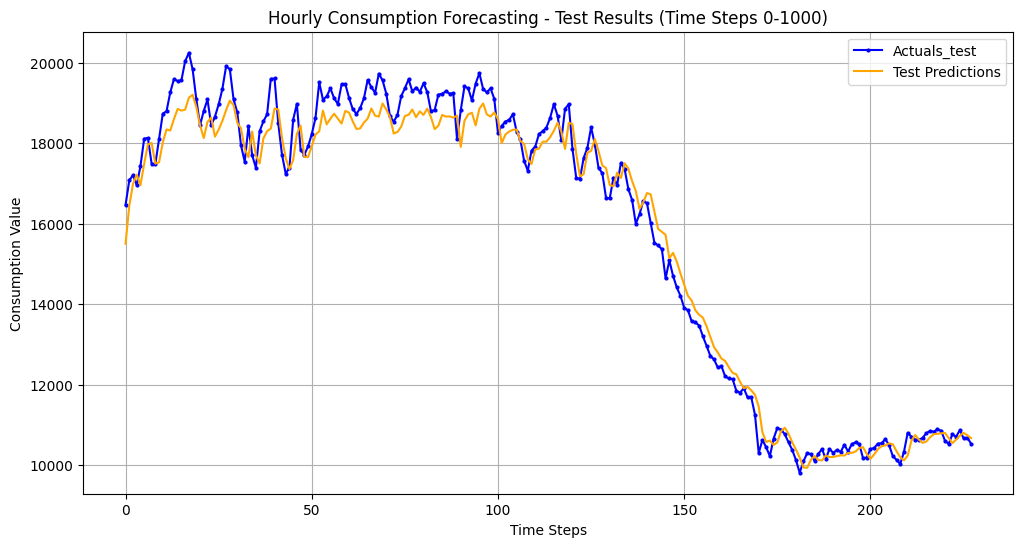

In [ ]:
import matplotlib.pyplot as plt

# Predict consumption using test data
test_predictions = best_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

ytest = ytest.reshape(ytest.shape[0], 1)
actual_test = scaler.inverse_transform(ytest)

# Create NumPy arrays for test predictions and actual values
test_predictions_array = test_predictions.flatten()
actual_test_array = actual_test.flatten()

# Create a DataFrame for easier plotting
test_results = pd.DataFrame({'Test Predictions': test_predictions_array, 'Actuals_test': actual_test_array})

# Plot the test results for a specific range of time steps (e.g., start_time and end_time)
start_time = 0  # Adjust the start time step as needed
end_time = 1000  # Adjust the end time step as needed

plt.figure(figsize=(12, 6))
plt.plot(test_results.index[start_time:end_time], test_results['Actuals_test'].iloc[start_time:end_time], label='Actuals_test', color='blue', marker='o', markersize=2)
plt.plot(test_results.index[start_time:end_time], test_results['Test Predictions'].iloc[start_time:end_time], label='Test Predictions', color='orange', linewidth=1.5)  # Orange and solid

plt.xlabel('Time Steps')
plt.ylabel('Consumption Value')
plt.title('Hourly Consumption Forecasting - Test Results (Time Steps {}-{})'.format(start_time, end_time))
plt.legend()
plt.grid(True)
plt.show()


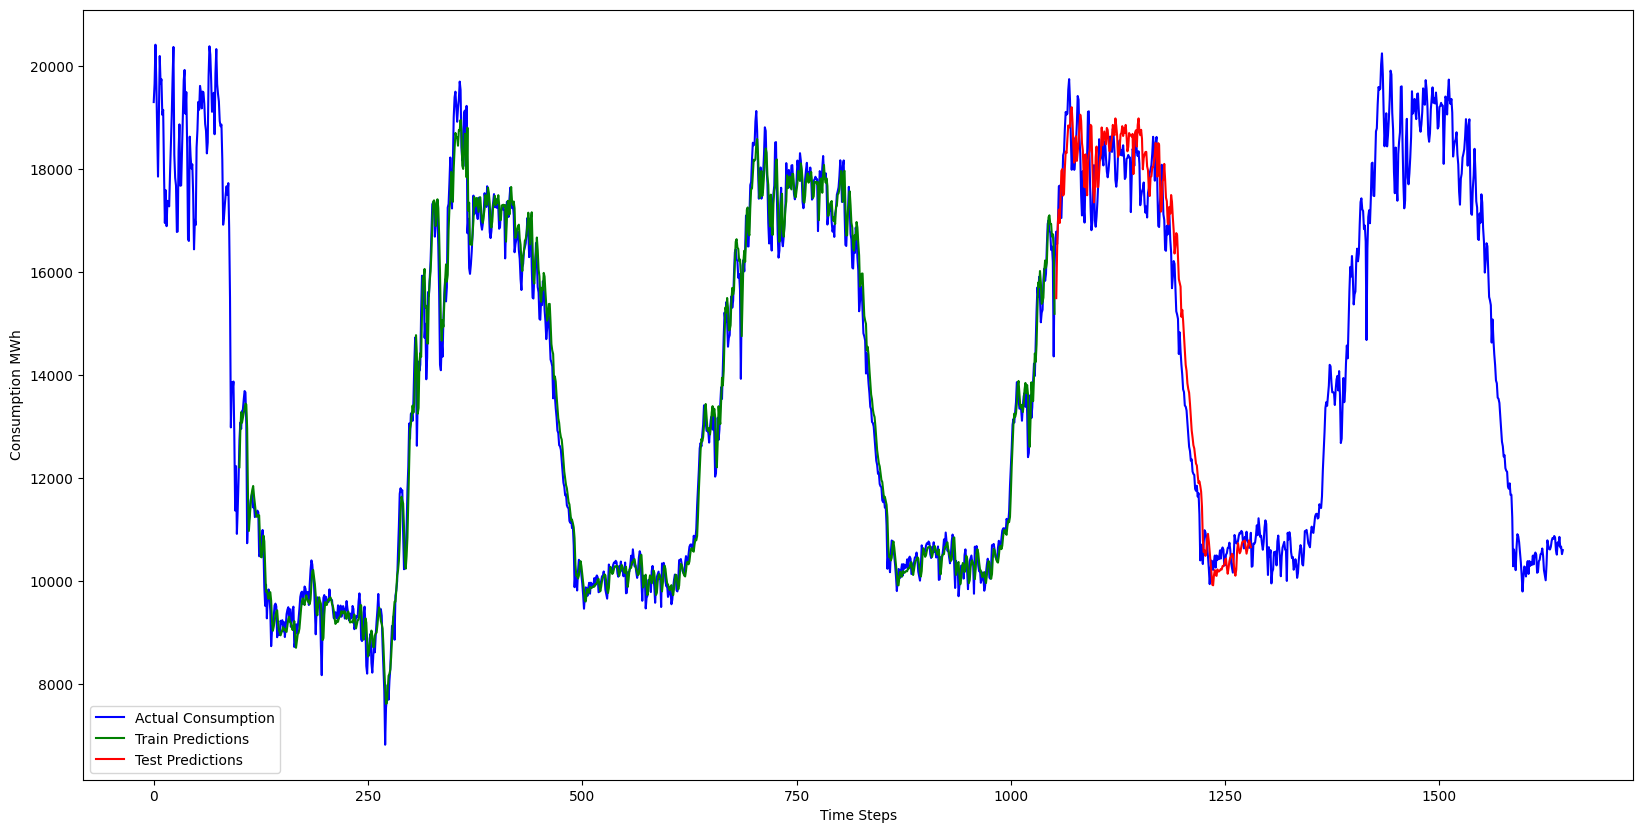

In [ ]:
# Define the length of your data
data_len = len(y)
look_back=100

# Create arrays for plotting
trainPredictPlot = np.empty((data_len, 1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : look_back + len(train_predictions), :] = train_predictions

testPredictPlot = np.empty((data_len, 1))
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back + len(train_predictions) + 1 : look_back + len(train_predictions) + 1 + len(test_predictions), :] = test_predictions

# Plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(y), color='blue')  # Actual Consumption (blue)
plt.plot(trainPredictPlot, color='green')  # Train Predictions (green)
plt.plot(testPredictPlot, color='red')  # Test Predictions (red)
plt.legend(['Actual Consumption', 'Train Predictions', 'Test Predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()



In [15]:
# Load the trained models
from keras.models import load_model

model_path1 = '/content/drive/MyDrive/Data_Science/01_Projects/04_Pakistan_Energy_Demand/Trained_models/CNN_LSTM'
model_path2 = '/content/drive/MyDrive/Data_Science/01_Projects/04_Pakistan_Energy_Demand/Trained_models/Stacked_LSTM'

model1 = load_model(model_path1)
model2 = load_model(model_path2)

# Make predictions using both models
train_predictions1 = model1.predict(X_train)
test_predictions1 = model1.predict(X_test)

train_predictions2 = model2.predict(X_train)
test_predictions2 = model2.predict(X_test)

# Create arrays for plotting
trainPredictPlot1 = np.empty((len(y), 1))
trainPredictPlot1[:, :] = np.nan
trainPredictPlot1[look_back : look_back + len(train_predictions1), :] = train_predictions1

testPredictPlot1 = np.empty((len(y), 1))
testPredictPlot1[:, :] = np.nan
testPredictPlot1[look_back + len(train_predictions1) + 1 : look_back + len(train_predictions1) + 1 + len(test_predictions1), :] = test_predictions1

trainPredictPlot2 = np.empty((len(y), 1))
trainPredictPlot2[:, :] = np.nan
trainPredictPlot2[look_back : look_back + len(train_predictions2), :] = train_predictions2

testPredictPlot2 = np.empty((len(y), 1))
testPredictPlot2[:, :] = np.nan
testPredictPlot2[look_back + len(train_predictions2) + 1 : look_back + len(train_predictions2) + 1 + len(test_predictions2), :] = test_predictions2

# Plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(y), color='blue')  # Actual Consumption (blue)
plt.plot(trainPredictPlot1, color='green')  # Train Predictions (green) from model 1
plt.plot(testPredictPlot1, color='red')  # Test Predictions (red) from model 1
plt.plot(trainPredictPlot2, color='cyan')  # Train Predictions (cyan) from model 2
plt.plot(testPredictPlot2, color='magenta')  # Test Predictions (magenta) from model 2
plt.legend(['Actual Consumption', 'Train Predictions (Model 1)', 'Test Predictions (Model 1)', 'Train Predictions (Model 2)', 'Test Predictions (Model 2)'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()


OSError: ignored

In [7]:
import numpy as np

def create_time_steps(data, time_steps=100):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Example usage:
input_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
X, y = create_time_steps(input_data, time_steps=4)

print("X:")
print(X)

print("\nY:")
print(y)


X:
[[ 1  2  3  4]
 [ 2  3  4  5]
 [ 3  4  5  6]
 [ 4  5  6  7]
 [ 5  6  7  8]
 [ 6  7  8  9]
 [ 7  8  9 10]
 [ 8  9 10 11]]

Y:
[ 5  6  7  8  9 10 11 12]
